In [29]:
import glob
import cv2
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report
import PIL.Image
import PIL.ImageDraw
import os
from pathlib import Path
import shutil
import time

In [30]:
lst_fire_img = glob.glob('/kaggle/input/fire-dataset/fire_dataset/fire_images/*.png')
lst_non_fire_img = glob.glob('/kaggle/input/fire-dataset/fire_dataset/non_fire_images/*.png')

In [31]:
print('Number of images with fire : {}'.format(len(lst_fire_img)))
print('Number of images with fire : {}'.format(len(lst_non_fire_img)))

Number of images with fire : 755
Number of images with fire : 244


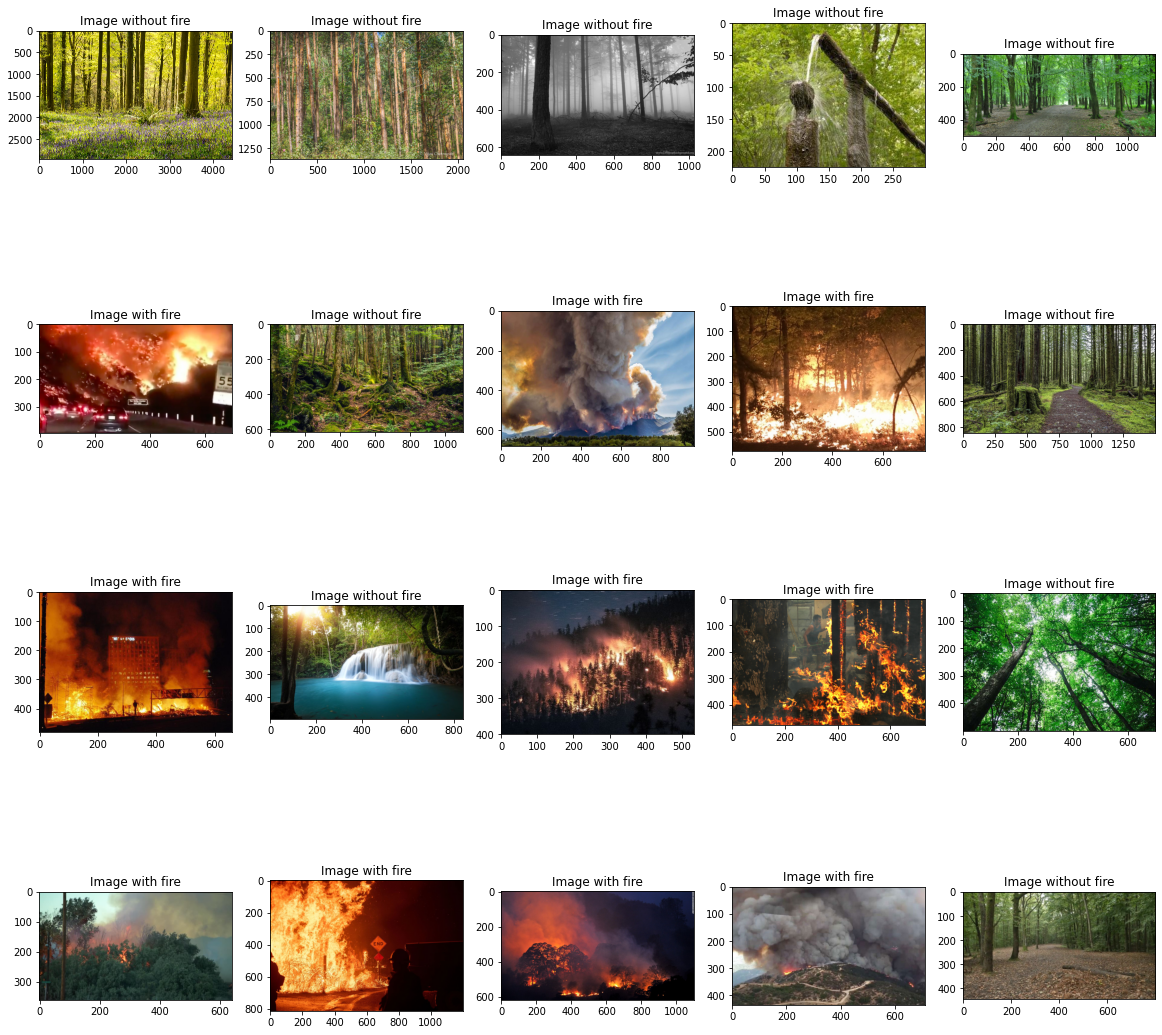

In [32]:
lst_images_random = random.sample(lst_fire_img,10) + random.sample(lst_non_fire_img,10)
random.shuffle(lst_images_random)

plt.figure(figsize = (20,20))

for i in range(len(lst_images_random)):
    
    plt.subplot(4,5,i+1)


    if "non_fire" in lst_images_random[i]:
        img = cv2.imread(lst_images_random[i])
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        plt.imshow(img,cmap = 'gray')
        plt.title('Image without fire')

    else:
        img = cv2.imread(lst_images_random[i])
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        plt.imshow(img,cmap = 'gray')
        plt.title("Image with fire")


plt.show()

We create a dataframe with filepath images and label (1 = fire , 0 = without fire)

In [33]:
lst_fire = []
for x in lst_fire_img:
  lst_fire.append([x,1])
lst_nn_fire = []
for x in lst_non_fire_img:
  lst_nn_fire.append([x,0])
lst_complete = lst_fire + lst_nn_fire
random.shuffle(lst_complete)

df = pd.DataFrame(lst_complete,columns = ['files','target'])
df.head(10)

,files,target
0,/kaggle/input/fire-dataset/fire_dataset/non_fi...,0
1,/kaggle/input/fire-dataset/fire_dataset/fire_i...,1
2,/kaggle/input/fire-dataset/fire_dataset/non_fi...,0
3,/kaggle/input/fire-dataset/fire_dataset/fire_i...,1
4,/kaggle/input/fire-dataset/fire_dataset/non_fi...,0
5,/kaggle/input/fire-dataset/fire_dataset/fire_i...,1
6,/kaggle/input/fire-dataset/fire_dataset/fire_i...,1
7,/kaggle/input/fire-dataset/fire_dataset/fire_i...,1
8,/kaggle/input/fire-dataset/fire_dataset/fire_i...,1
9,/kaggle/input/fire-dataset/fire_dataset/fire_i...,1


In [34]:
filepath_img = '/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.189.png'
df = df.loc[~(df.loc[:,'files'] == filepath_img),:]

In [35]:
df.shape

(998, 2)

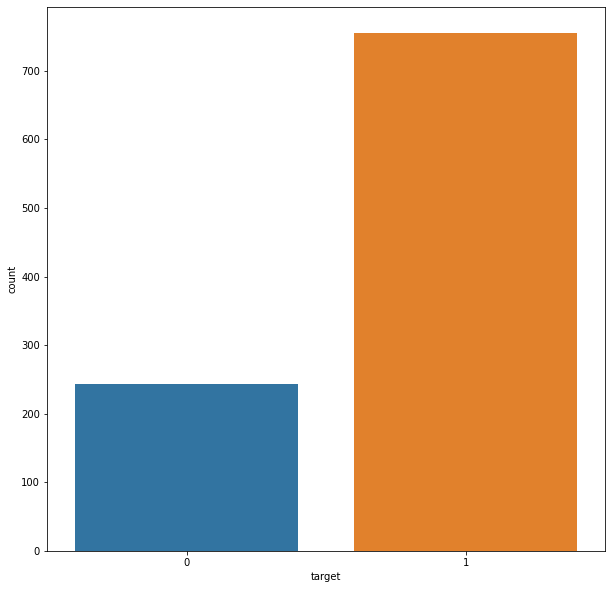

In [36]:
plt.figure(figsize = (10,10))
sns.countplot(x = "target",data = df)
plt.show()

In [37]:
# for pi in range(0,20,2,):
#     # Read positive samples
#     im = PIL.Image.open(lst_fire_img).resize(10,10))
#     display(im)
#     mask = PIL.Image.open(lst_fire_img).resize((10,10))
#     display(mask)

# for ni in range(0,len(lst_non_fire_img),100):
#     # Read negative samples
#     im = PIL.Image.open(lst_non_fire_img).resize(10,10))
#     display(im)

## Preprocessing

In [38]:
def preprocessing_image(filepath):
  img = cv2.imread(filepath) #read
  img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) #convert
  img = cv2.resize(img,(196,196))  # resize
  img = img / 255 #scale
  return img 

We create numpy array X and y . X are 998 images with (196,196,3) shape, y the target is (998,) shape

In [39]:
def create_format_dataset(dataframe):
  X = []
  y = []
  for f,t in dataframe.values:
    X.append(preprocessing_image(f))
    y.append(t)
  
  return np.array(X),np.array(y)

In [40]:
X, y = create_format_dataset(df)

In [41]:
X.shape,y.shape

((998, 196, 196, 3), (998,))

### we split the data in train and test

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,stratify = y)

In [43]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((698, 196, 196, 3), (300, 196, 196, 3), (698,), (300,))

In [44]:
# model = Sequential()

# model.add(Conv2D(128,(2,2),input_shape = (196,196,3),activation='relu'))
# model.add(Conv2D(64,(2,2),activation='relu'))
# model.add(MaxPooling2D())
# model.add(Conv2D(32,(2,2),activation='relu'))
# model.add(MaxPooling2D())

# model.add(Flatten())
# model.add(Dense(128))
# model.add(Dense(1,activation= "sigmoid"))

In [45]:
# AlexNet model
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape = (196,196,3)
#                         kernel_initializer= 'he_normal'
                       ))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
#                         kernel_initializer= 'he_normal'
                       ))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
#                         kernel_initializer= 'he_normal'
                       ))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
#                         kernel_initializer= 'he_normal'
                       ))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
#                         kernel_initializer= 'he_normal'
                       ))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(1,activation= "sigmoid"))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [46]:
model = AlexNet((227, 227, 3), 1)

2022-06-02 07:09:53.109285: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [47]:
model.summary()

Model: "alex_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 47, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 256)       884

In [48]:
callbacks = [EarlyStopping(monitor = 'val_loss',patience = 10,restore_best_weights=True)]
model.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 30,batch_size = 32,callbacks = callbacks)

2022-06-02 07:09:54.349934: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
22/22 [==============================] - 40s 2s/step - loss: 3.8269 - accuracy: 0.7564 - val_loss: 0.4400 - val_accuracy: 0.7567
Epoch 2/30
22/22 [==============================] - 35s 2s/step - loss: 0.4235 - accuracy: 0.7479 - val_loss: 0.4516 - val_accuracy: 0.8200
Epoch 3/30
22/22 [==============================] - 35s 2s/step - loss: 0.3532 - accuracy: 0.8410 - val_loss: 0.3266 - val_accuracy: 0.8500
Epoch 4/30
22/22 [==============================] - 36s 2s/step - loss: 0.4281 - accuracy: 0.8181 - val_loss: 0.2931 - val_accuracy: 0.8700
Epoch 5/30
22/22 [==============================] - 35s 2s/step - loss: 0.2932 - accuracy: 0.8983 - val_loss: 0.3179 - val_accuracy: 0.8633
Epoch 6/30
22/22 [==============================] - 35s 2s/step - loss: 0.2625 - accuracy: 0.8696 - val_loss: 0.3020 - val_accuracy: 0.7600
Epoch 7/30
22/22 [==============================] - 35s 2s/step - loss: 0.2692 - accuracy: 0.8754 - val_loss: 0.2941 - val_accuracy: 0.8767
Epoch 8/30
22/22 [==

In [49]:
y_pred = model.predict(X_test)

In [50]:
y_pred = y_pred.reshape(-1)
y_pred[y_pred<0.5] = 0
y_pred[y_pred>=0.5] = 1
y_pred = y_pred.astype('int')

In [51]:
y_pred

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1])

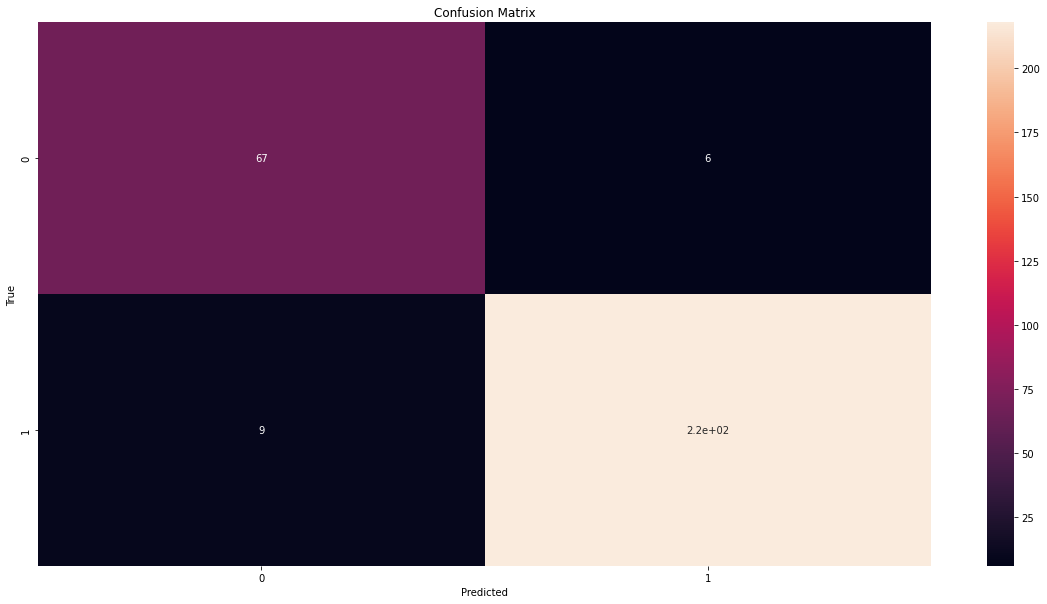

In [52]:
plt.figure(figsize = (20,10))

sns.heatmap(confusion_matrix(y_test,y_pred),annot = True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

## Saving the model

In [53]:
!mkdir -p TrainedModels
model.save('TrainedModels/Fire-intial-v1.h5')

# Testing

In [54]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.preprocessing import image
import cv2

In [55]:
new_model = tf.keras.models.load_model('TrainedModels/Fire-intial-v1.h5')

# Check its architecture
new_model.summary()

ValueError: Unknown layer: AlexNet. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
def preprocessing_image(filepath):
  img = cv2.imread(filepath) #read
  img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) #convert
     # Plot image
  figure = plt.figure(figsize=(10, 10))
  plt.imshow(img)
  plt.xlabel(img.shape)
  img = cv2.resize(img,(196,196))  # resize
  img = img / 255 #scale
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  return images 

In [ ]:
#image_path = "../input/fire-dataset/fire_dataset/non_fire_images/non_fire.191.png"
image_path = '../input/fire-dataset/fire_dataset/fire_images/fire.199.png'
images = preprocessing_image(image_path)
classes = new_model.predict(images, batch_size=1)
#classes = classes.argmax(axis=-1)
print(classes)

In [ ]:
import tensorflow as tf
model ='TrainedModels/Fire-intial-v1.h5'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)  